# MNIST and Adversarial Noise 

In this code, an adversarial noise that cause a learned model to always mis-classify 2 as 6 will be learned. MNIST dataset which contains 55000 samples as training set, 10000 samples as testing set, and 5000 samples as validation set will be used. Each image in MNIST is a hard-written digit image of size 28X28. Moreover, Numpy and TensorFlow will be used.

### CNN Architecture

The CNN used in this code is inspired by the official Tensorflow tutorial. It consists of 2 convolution layers and 2 fully connected layers. The input image will be
a combined image of a hand written digit image of size 28X28 and the adversarial noise image of 
size 28X28, see below for more details.

This CNN has two optimizations, the two optimizations are completely separate. The first optimizer is designed to train the model to classify the digits with high level of accuracy, it tries to minimize the softmax loss of training set using Adam optimization. In this phase, I only initialize the weights of the CNN to predict the correct number of any image with high level of accuracy, the model achieves an accuracy of 99.2% in the testing set. On the other hand, the second optimizer tries to minimize the combined loss of L2 loss and softmax to find the adversarial noise that will fool the model that we already trained to mis-classify 2 to 6, I also use Adam optimization to minimize the combined loss.

It is worth mentioning, in the first optimization all variable will be trained but the noise variable, it will be trained only in the second optimization process.

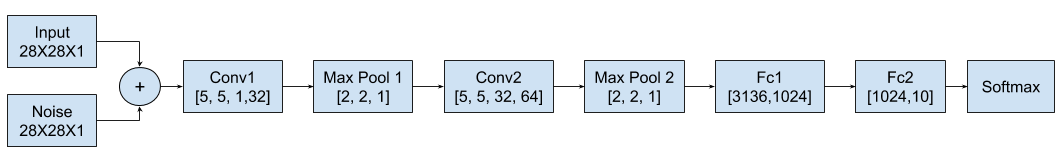

In [178]:
from IPython.display import Image
#Show the CNN Architecture
Image('cnn.png')

#### Import the required libraries to run the code

In [179]:
%matplotlib inline
import tensorflow as tf 
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

### Load Data

The data is located in the same directory. If the data is not there, it will be downloaded automatically. Moreover, each image in the dataset is stored as one-dimensional array of size 28*28, and the labels of each image are represented as one-hot representation, each label is an array of size 10 such that all elements are zero but the true label index is 1 

In [180]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST dataset is now loaded. As mentioned above the dataset contains 55000 images for training, 10000 images for testing, and 5000 for validation.

In [181]:
# Some stats about the MNIST dataset
print('--------------------')
print("Training-set: " + str(len(mnist.train.labels)))
print("Test-set: " + str(len(mnist.test.labels)))
print("Validation-set: " + str(len(mnist.validation.labels)))

--------------------
Training-set: 55000
Test-set: 10000
Validation-set: 5000


### Initialize data related varaibles

Initialize some variable that will be used in several places in the code. Also, it will make the code configurable with latest amount of change

In [182]:
#Width of the input image 
mnist_img_width = 28
#Height of the input iamge
mnist_img_height = 28
#Number of channels
mnist_img_num_channel = 1
#Number of the classes (0-9)
num_classes = 10
#The data in the dataset is stored in one dimensional array of size image_width X image_height
mnist_flat_image = mnist_img_width * mnist_img_height
#Number of results to show
number_of_rows = 10

### Initialize adversarial noise related variables

The adversarial noise is a value that will be added or subtracted from the original image. We set the limit of this value here, the noise will be in range [delta, -delta]. If delta is set very low the noise will be bright which will cause the original image pixels to be bright. However, if delta is set very high the noise pixels will be dark which will cause the original image pixels to be dark. 

In [183]:
#Set the adversarial noise limit, the noise will be between [delta, -delta]
delta = 0.5

### Initialize training related variables

Initialize some variables that will be used for training purposes. Also, it will make the code configurable with latest amount of change

In [184]:
# Number of training steps for MNIST classification
minst_train_step = 1000
# Number of training steps for Adversarial Noise
noise_train_step = 1000
# Batch size per step
batch_size = 64
# The weight of L2 Loss. Since adverserial loss is a combantion of two losses, softmax and l2.
# This paramter sets how important the L2 loss comparing with the softmax loss
l2_weight = 0.01

### Create the CNN

Each convolution and fully connected layer require weights and bais variables. Therefore, the next two functions will help create them. The weights are initialized based on the truncated normal distribution with standard deviation of 0.1, this way we prevent zero gradients. Also, the bais variable is initialized with a small positive number to avoid dead neurons  

In [185]:
# Create Weights variable of a given shape
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)

In [186]:
# Create a bais variable of a given shape
def bais_variable(shape):
	initial = tf.constant(0.1, shape=shape)
	return tf.Variable(initial)

Now we create the CNN as descriped above. It consists of 2 convolution layers and 2 fully connected layers. The input image will be a combined image of a hand written digit image of size 28X28 and the adversarial noise image of 
size 28X28

In [187]:
#This model is inspired by the official tensorflow tutorial
#I made some changes to create scops when necessary to make the visualization easier if you want to use tensorbored
#https://www.tensorflow.org/tutorials/mnist/pros/
def cnn_model(image, keep_prob):
	#Create a conv layer of filter size 5X5, stride 1, and depth 32
	with tf.variable_scope('conv1') as scope:
		W_conv1 = weight_variable([5, 5, 1, 32])
		b_conv1 = bais_variable([32])

		conv = tf.nn.conv2d(image, W_conv1, [1, 1, 1, 1], padding='SAME')
		pre_activation = tf.nn.bias_add(conv, b_conv1)
		conv1 = tf.nn.relu(pre_activation, name=scope.name)
    #Create a max pooling layer of filter size 2X2, stride 1
	pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
	                         padding='SAME', name='pool1')
	#Create a conv layer of filter size 5X5, stride 1, and depth 64
	with tf.variable_scope('conv2') as scope:
		W_conv2 = weight_variable([5, 5, 32, 64])
		b_conv2 = bais_variable([64])

		conv = tf.nn.conv2d(pool1, W_conv2, [1, 1, 1, 1], padding='SAME')
		pre_activation = tf.nn.bias_add(conv, b_conv2)
		conv2 = tf.nn.relu(pre_activation, name=scope.name)
    #Create a max pooling layer of filter size 2X2, stride 1
	pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1],
	                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    #Create a fully connected of size [7 * 7 * 64, 1024]
	with tf.variable_scope('fc1') as scope:
		W_fc1 = weight_variable([7 * 7 * 64, 1024])
		b_fc1 = bais_variable([1024])

		pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
		fc1 = tf.nn.relu(tf.matmul(pool2_flat, W_fc1) + b_fc1, name=scope.name)
    #Create a drop out layer for regulization
	fc1_drop = tf.nn.dropout(fc1, keep_prob)
    
    #Create a fully connected of size [1024, 10]
	with tf.variable_scope('softmax_linear') as scope:
		W_fc2 = weight_variable([1024, 10])
		b_fc2 = bais_variable([10])

		softmax_linear = tf.add(tf.matmul(fc1_drop, W_fc2), b_fc2, name=scope.name)

	return softmax_linear

A function to calculate the softmax loss of a batch given the true labels

In [188]:
#calculate the softmax loss
def softmax_loss(logits, labels):
	cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels, name='cross_entropy_per_example')
	mean_cross_entropy = tf.reduce_mean(cross_entropy, name='cross_entropy')
	return mean_cross_entropy

A function to calculate the L2 loss of the noise image

In [189]:
#calculate the L2 loss
def l2_loss(noise_image, l2_weight):
	return l2_weight * tf.nn.l2_loss(noise_image)

A function to create adam optimization. Each optimization will use different learning rate and optimize different sets of variables, the first optimization will change the values of all variable in the network but the noise variable. However, the second optimization will change only the noise variable. We can pass the list of variables that we want to optimize to the function through var_list parameter  

In [190]:
#Perform one step optimization for the given variable list using a given lr
def adam_optimizer(loss, lr=None, var_list=None):
	optimizer = tf.train.AdamOptimizer(lr).minimize(loss, var_list=var_list)
	return optimizer

Define a placeholder for the input image/s. This placeholder allows us to change the input image/s when the graph is executed. The shape of this placeholder is set to [None, mnist_flat_image] which means it can take any number of images of length 28*28

In [191]:
#Placeholder for the input image/s
#The shape of X is [None, minst_flat_image]
#None: means the placeholder can take any number of images
x = tf.placeholder(tf.float32, shape=[None, mnist_flat_image], name='x')

Define a placeholder for the true labels of the input image/s. This placeholder allows us to change the input image/s when the graph is executed. The shape of this placeholder is set to [None, num_classes] which means it can take any number of labels of length 10

In [192]:
#Placeholder for the true value of the input image/s
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')

Define a placeholder to control the dropout probability. This placeholder will allow us to control the dropout while executing the graph. It is usually 0.5 while training so we can prevent overfitting and it is 1.0 when doing inferencing so we make sure all neurones are active.

In [193]:
#Dropout parameter for regularization 
#During training it will be set to 0.5
#During testing it will be set to 1.0
#See below
keep_prob = tf.placeholder(tf.float32)

The MNIST data is stored as one-dimensional array of length 28*28. However, the CNN is expecting an input is an image of size 28X28. Therefore, the input data from MNIST should be reshaped to proper shape [28X28] image. 

In [194]:
#Since the input is one dimensional array of size image_width X image_height
#The CNN expects the input is an image
#We reshape the input data to [image_width, image_height, number_of_channels]
x_image = tf.reshape(x, [-1, mnist_img_width, mnist_img_height,mnist_img_num_channel])

Define a variable for the adversarial noise. It is the same size of the input image [28X28]. Also, it is initialized to zero so it will not have an effect when performing the first optimization. Moreover, we don't train this variable in the first optimization. Therefore, we set the trainable=False.

In [195]:
#Variable for the adversarial noise
#The shape of the noise image will be the same as the input image [image_width, image_height, number_of_channels]
#This variable will not be trained along with the rest of the variable when we train MNIST dataset for
#classification. Therefore, trainable will be set to false
noise_img = tf.Variable(tf.zeros([mnist_img_width, mnist_img_height, mnist_img_num_channel]),
                      name='noise_img', trainable=False)

After performing optimization to the adversarial noise, we need to make sure the new values are within the delta limit that we have above.

In [196]:
#The adversarial noise will be clipped to the give delta
noise_img_clip = tf.assign(noise_img, tf.clip_by_value(noise_img, -delta, delta))

As mentioned in the CNN architecture figure, the input image is a combined image of the original image and noise

In [197]:
#Add the noise to the input image
#Note: The input image will not be affected in the first optimizatin since the noise will be zero
x_noisy_image = x_image + noise_img

After summing up the original image and the adversarial noise, we need to make sure the new values are within the range [0, 1].

In [198]:
#We want to make sure the image values are still in range. 
#Therefore, The image is clipped between [0, 1]
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

Use the helper function that we define above to pass the noisy image/s through the CNN along with the drop out probablility.

In [199]:
#Calculate logists of in the input image/s
logits = cnn_model(x_noisy_image, keep_prob)

Use the helper function we defined above to calculate the softmax loss of the noisy images and the true labels

In [200]:
#Compute softmax cross entropy loss 
softmax_loss = softmax_loss(logits, y)

Use the helper function we define above to minimize the softmax loss of the training data. This is the first optimization that is designed for MNIST classification

In [201]:
#Perform one step optimization using Adam optimization to minimize the softmax loss
softmax_mnist_optimizer = adam_optimizer(softmax_loss, lr=1e-4)

Use the helper function we defined above to calculate the L2 loss of the adversarial noise image

In [202]:
#Compute the L2 loss given the noise image
l2_noise_loss = l2_loss(noise_img, l2_weight)

Combine the softmax loss and the L2 loss for the second optimization

In [203]:
#Add the softmax loss and l2 loss for the adversarial noise optimization
combined_loss = softmax_loss + l2_noise_loss

Use the helper function we define above to minimize the combined loss. This is the second optimization that is designed to find the adversarial noise

In [204]:
#Perform one step optimization to minimize the combined loss
#Since this optimization does not update all variable in the network, we need to 
#Tell the optimizer what variable should be optimized via var_list
noise_optimizer = adam_optimizer(combined_loss, lr=1e-3, var_list=[noise_img])

### Performance Evaluation

To make sure the model is training and the accuracy is increasing. We calculate the accuracy of the model every certain steps of training. First, we count the number of images that the model predicted correctly then we divide it by the number of testing set.

In [205]:
#Vector of boolean to show if the predicted class equals the true class of an image/s
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))

In [206]:
#Calculate the accuracy of the model
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow

At this moment nothing is executed and the optimizations have not been performed yet. We only defined the graph, loss, and optimizations. To execute the graph we need to create a session in Tensorflow.

In [207]:
# Create a tensorflow session to execute the graph and train the models
sess = tf.Session()

The variables of weights and baies should be initialized before using them when we perform optimization.

In [208]:
#Initialize all variables but the noise variable
sess.run(tf.global_variables_initializer())

In the above code all weights and baies variables were initialized but the adversarial noise variable. Therefore, we need to tell Tensorflow to initialize it as well

In [209]:
#Initialize the adversarial variable
sess.run(tf.variables_initializer([noise_img]))

After all variable have been initialized, we can start training the model for classification. We perform a number of optimization steps to update the weights to make the model better, you can set the number of training iteration using minist_train_step that is defined above. In each iteration, we take a batch from the training set and Tensorflow perform optimization on the variables using this batch. We continue training until we achieve the results that we are looking for. The performance of the model will be printed every 100 iterations.  

In [210]:
#Train the CNN with minst_train_step iteration
#You can get an accuracy of 99.2% if you train the model for 20,000 iterations
#It may take some time depends if you are using GPU or CPU
for i in range(minst_train_step):
    #Extract a batch from the training set
	x_batch, y_batch = mnist.train.next_batch(batch_size)
    #Check if the number of iteration is i % 100 so we can test the model
	if i % 100 == 0:
        #Calculate the accuracy of the current batch
		train_acc = sess.run([accuracy], feed_dict={x:x_batch, y: y_batch, keep_prob: 1.0})
		print("Step " + str(i) + " , Train Acc: " + str(train_acc))
    #Execute one step of optimization give the x_batch, and y_batch
	sess.run([softmax_mnist_optimizer], feed_dict={x:x_batch, y:y_batch, keep_prob:0.5})

Step 0 , Train Acc: [0.109375]
Step 100 , Train Acc: [0.9375]
Step 200 , Train Acc: [0.8125]
Step 300 , Train Acc: [0.890625]
Step 400 , Train Acc: [0.890625]
Step 500 , Train Acc: [0.890625]
Step 600 , Train Acc: [0.96875]
Step 700 , Train Acc: [0.953125]
Step 800 , Train Acc: [0.953125]
Step 900 , Train Acc: [0.96875]


After finishing training the model, we can test the performance using the testing set. As you can see the model is able to achieve an accuracy of 96.6% only using 1000 training iteration. However, if you set the training step to 20K iterations, you can achieve an accuracy of 99.2%, it takes time.

In [211]:
#Now the model is trained 
#Test the model using the testing dataset
test_acc = sess.run([accuracy], feed_dict={x: mnist.test.images, 
	y: mnist.test.labels, keep_prob: 1.0})

In [212]:
print("Test Acc: " + str(test_acc))

Test Acc: [0.96320015]


Now, the model is able to recognize any hand-written digit with high level of accuracy. It is time to train an adversarial noise that will fool this model to think an image is 2 is an image of 6 with high level of accuracy. In this step, we perform a number of optimization steps to update the noise variable to create a unique pattern that is able to fool the CNN, you can set the number of training iteration using noise_train_step that is defined above. In each iteration, we take a batch from the training set. Then, we take only the images of number 2 and change their true labels to 6. Finally, Tensorflow perform optimization on the adversarial noise variable using this batch. 

In [213]:
#Train the adversarial noise with noise_train_step
#You can get the noise when performing 1000 iterations 
for i in range(noise_train_step):
    #Extract a batch from the training set
	x_batch, y_batch = mnist.train.next_batch(batch_size)
    
    #Find the images of number 2 from the batch
	samples_indx = np.where(y_batch[:, 2] == 1)[0]

    #Update the true values of those images to 6
	y_batch[samples_indx, 2] = 0
	y_batch[samples_indx, 6] = 1

    #Check if the batch does not have images of number 2
	if x_batch[samples_indx, :].shape[0] == 0:
		continue

    #Execute one step of optimization give the x_batch, and the updated y_batch
	sess.run([noise_optimizer], feed_dict={x:x_batch[samples_indx, :], y:y_batch[samples_indx, :], keep_prob:0.5})
    #Make sure the new values of the adversarial noise are within range
	sess.run(noise_img_clip)

    #print a message every 100 iterations
	if i % 100 == 0:
		print("Done with " + str(i) + " iterations")

Done with 0 iterations
Done with 100 iterations
Done with 200 iterations
Done with 300 iterations
Done with 400 iterations
Done with 500 iterations
Done with 600 iterations
Done with 700 iterations
Done with 800 iterations
Done with 900 iterations


After finishing training the adversarial noise, it is time to test it. We create a softmax layer to get the predicated rank of the original image before and after adding the adversarial noise. Also, a plot of 10X3 is created such that the fist column is the original image, the second column is the noise, and the final column is the original image after adding the noise. Also, above each cell in the plot is some information such as the true label, the predicted label of the original image, delta, and the predicted label after adding the noise.

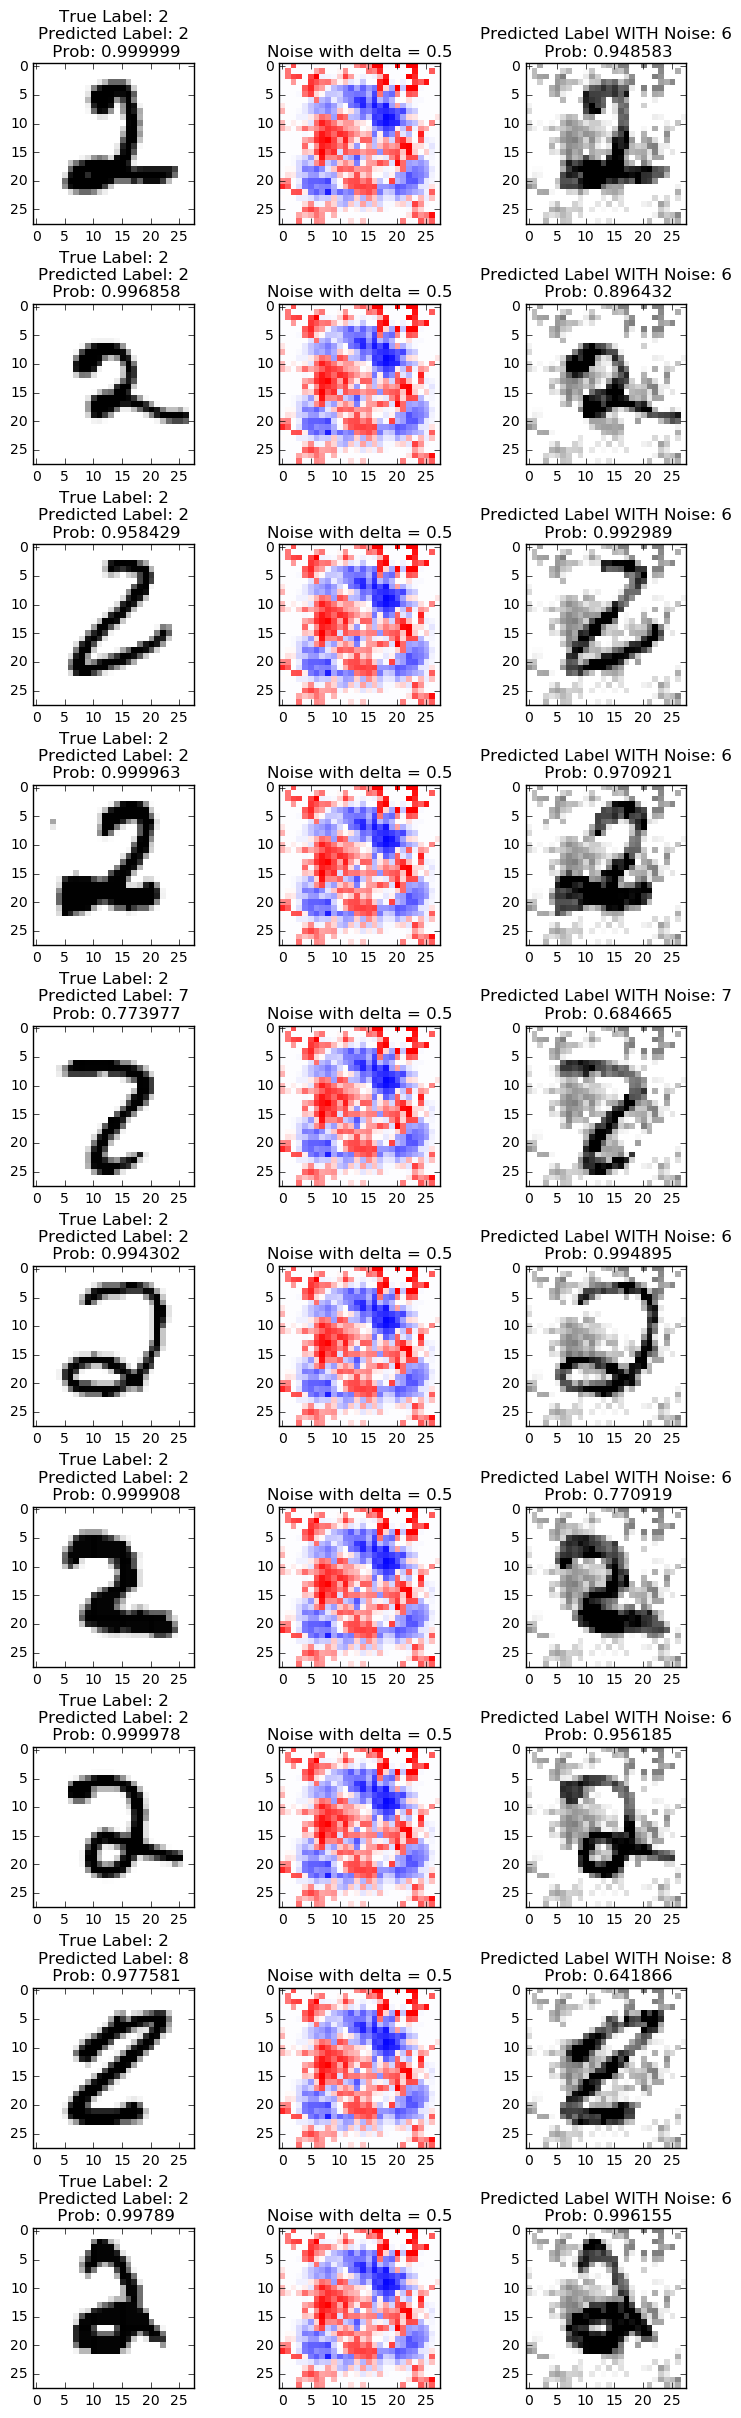

In [214]:
#Create a softmax layer to get the rank of each label
softmax = tf.nn.softmax(logits)

#Variable to keep track of how many images with label 2 have been seen
count = 0 

#Create a plot of 10X3 
f, axarr = plt.subplots(number_of_rows, 3, figsize=(9, 30))

#Iterate over the training set to find 10 images with label 2
#It can be done without while loop only using numpy operation but I want 
#In each run you get different samples of images with label 2

while True:
    #get an image from the training set 
    x_batch, y_batch = mnist.train.next_batch(1)
    
    #check if the image is 2
    if np.argmax(y_batch) != 2:
        continue
    
    #Since the input is one dimensional array of size image_width X image_height
    #The CNN expects the input is an image
    #We reshape the input data to [image_width, image_height, number_of_channels]
    image = x_batch.reshape((28, 28, 1))
    
    #Get the value of the noise from the graph
    noise = sess.run(noise_img)
    
    #Combine the input image with the loss
    image_with_noise = image + noise
    
    #Make sure the image is within range [0, 1]
    image_with_noise = np.clip(image_with_noise, 0.0, 1.0)

    #Subtract the noise from the image so when we feed the image with noise to the network
    #It will be the original image
    image_without_noise = image - noise
    
    #Reshape the image without noise from [image_width, image_height] to [1, image_width * image_height]
    image_without_noise = image_without_noise.reshape((1, mnist_flat_image))

    #Get the probability of the image with noise 
    probabilites_with_noise = sess.run([softmax], feed_dict={x:x_batch, keep_prob:1.0})
    
    #Get the probability of the original image
    probabilites_without_noise = sess.run([softmax], feed_dict={x:image_without_noise, keep_prob:1.0})

    #Plot the results along with the probability
    axarr[count, 0].imshow(image[:, :, 0], cmap='binary', interpolation='nearest')
    axarr[count, 0].set_title('True Label: ' + str(np.argmax(y_batch)) + '\nPredicted Label: ' + str(np.argmax(probabilites_without_noise)) +
                              '\n Prob: ' + str(np.max(probabilites_without_noise)))
    axarr[count, 1].imshow(np.squeeze(noise), interpolation='nearest', cmap='seismic',vmin=-1.0, vmax=1.0)
    axarr[count, 1].set_title('Noise with delta = ' + str(delta))
    axarr[count, 2].imshow(image_with_noise[:, :, 0], cmap='binary', interpolation='nearest')
    axarr[count, 2].set_title('Predicted Label WITH Noise: ' + str(np.argmax(probabilites_with_noise)) +
                       '\n Prob: ' + str(np.max(probabilites_with_noise)))
    
    count += 1
    #Check if the number of images that have been seen equals the number of rows
    if count == number_of_rows:
        break
#Adjust the plot spacing 
f.subplots_adjust(hspace=0.5)
#Save the plot in the same directory
f.savefig('2_to_6_with_delta_' + str(delta) +'.png')   # save the figure to file
#Show plot
plt.show()

#### Delta = 0.2

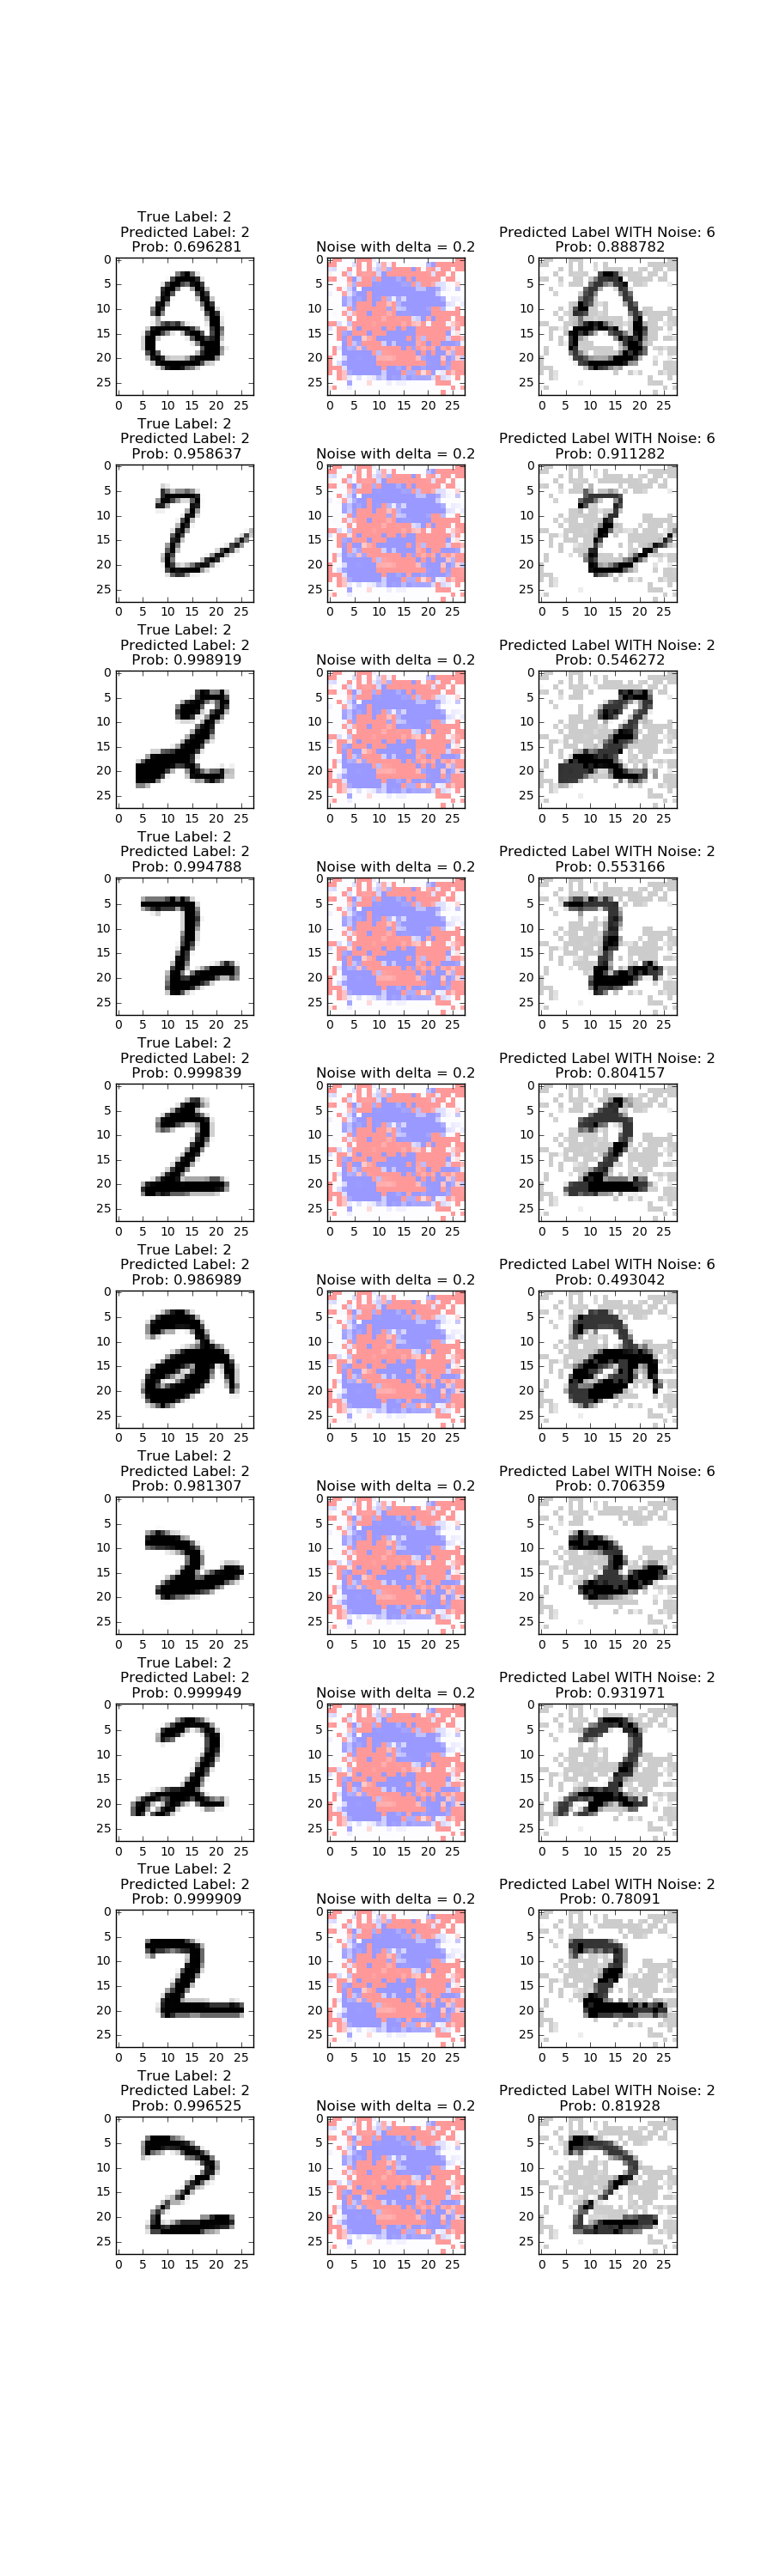

In [215]:
#Show results when delta = 0.2
Image('2_to_6_with_delta_0.2.png')

#### Delta = 0.4

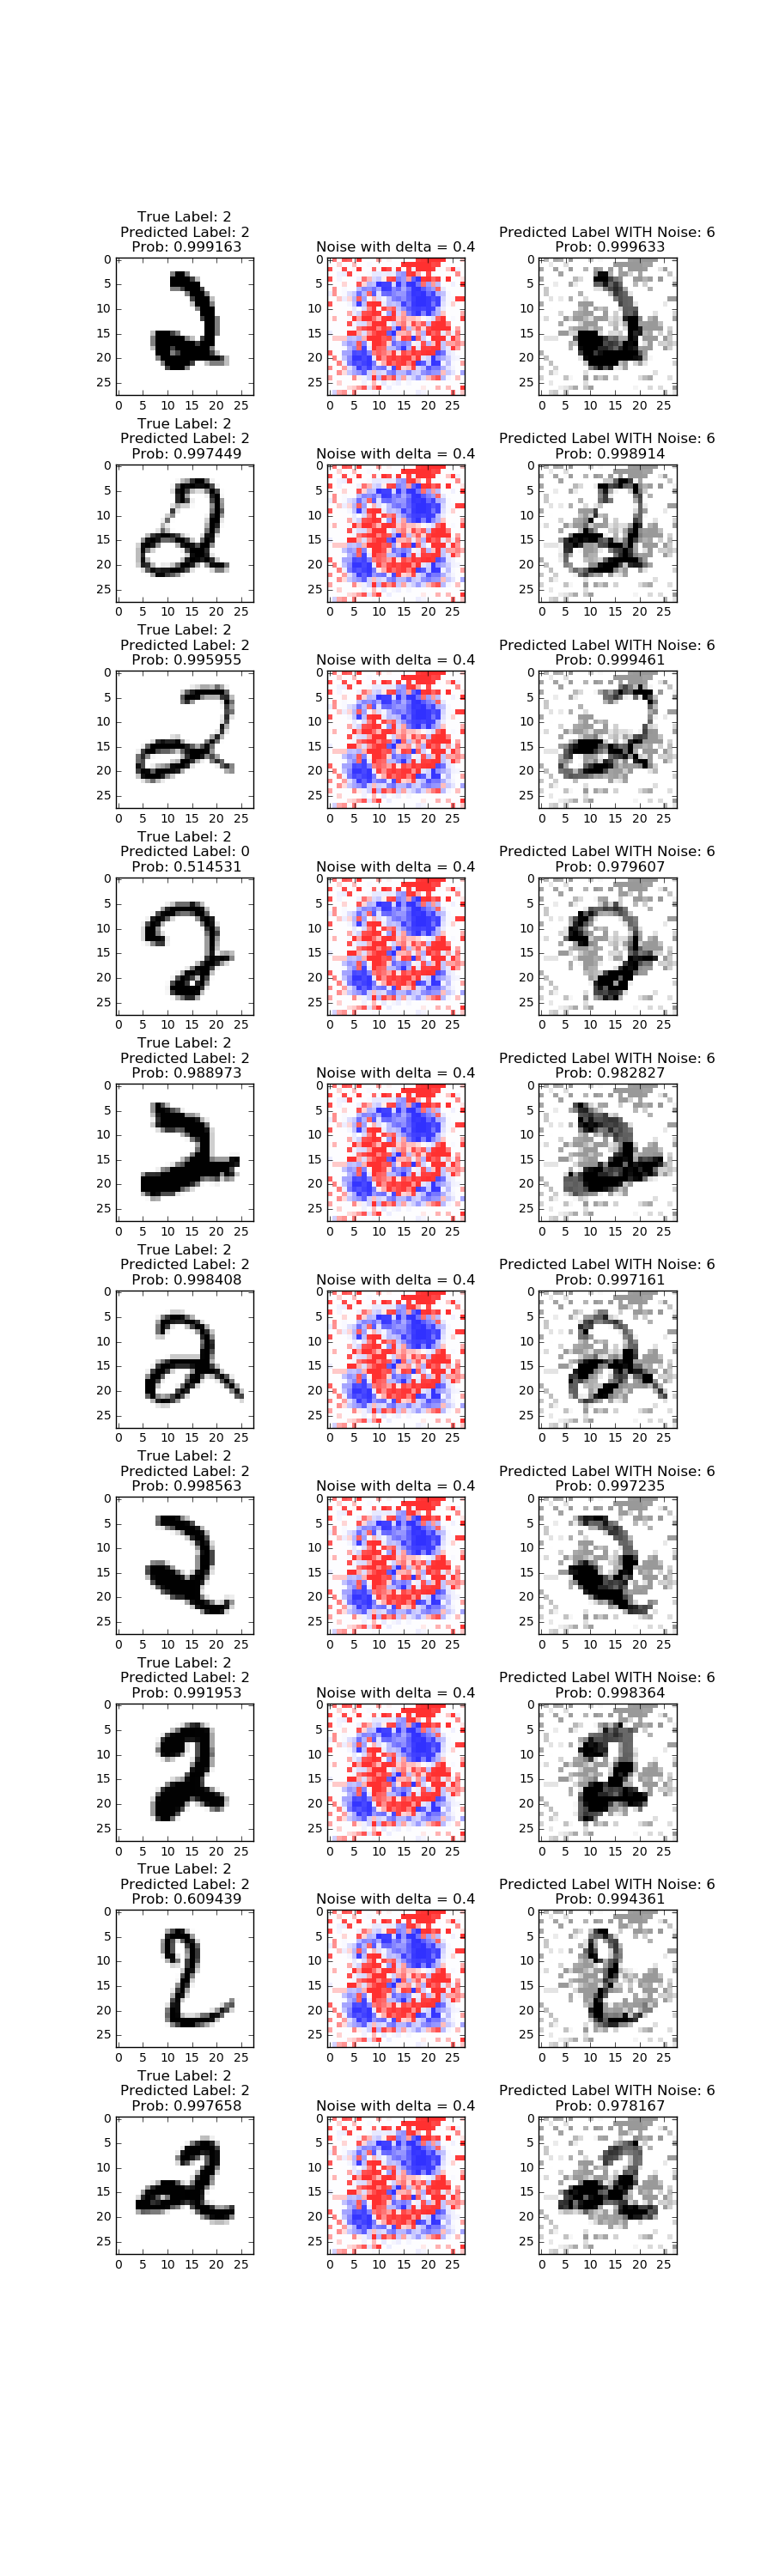

In [216]:
#Show results when delta = 0.4
Image('2_to_6_with_delta_0.4.png')

#### Delta = 0.6

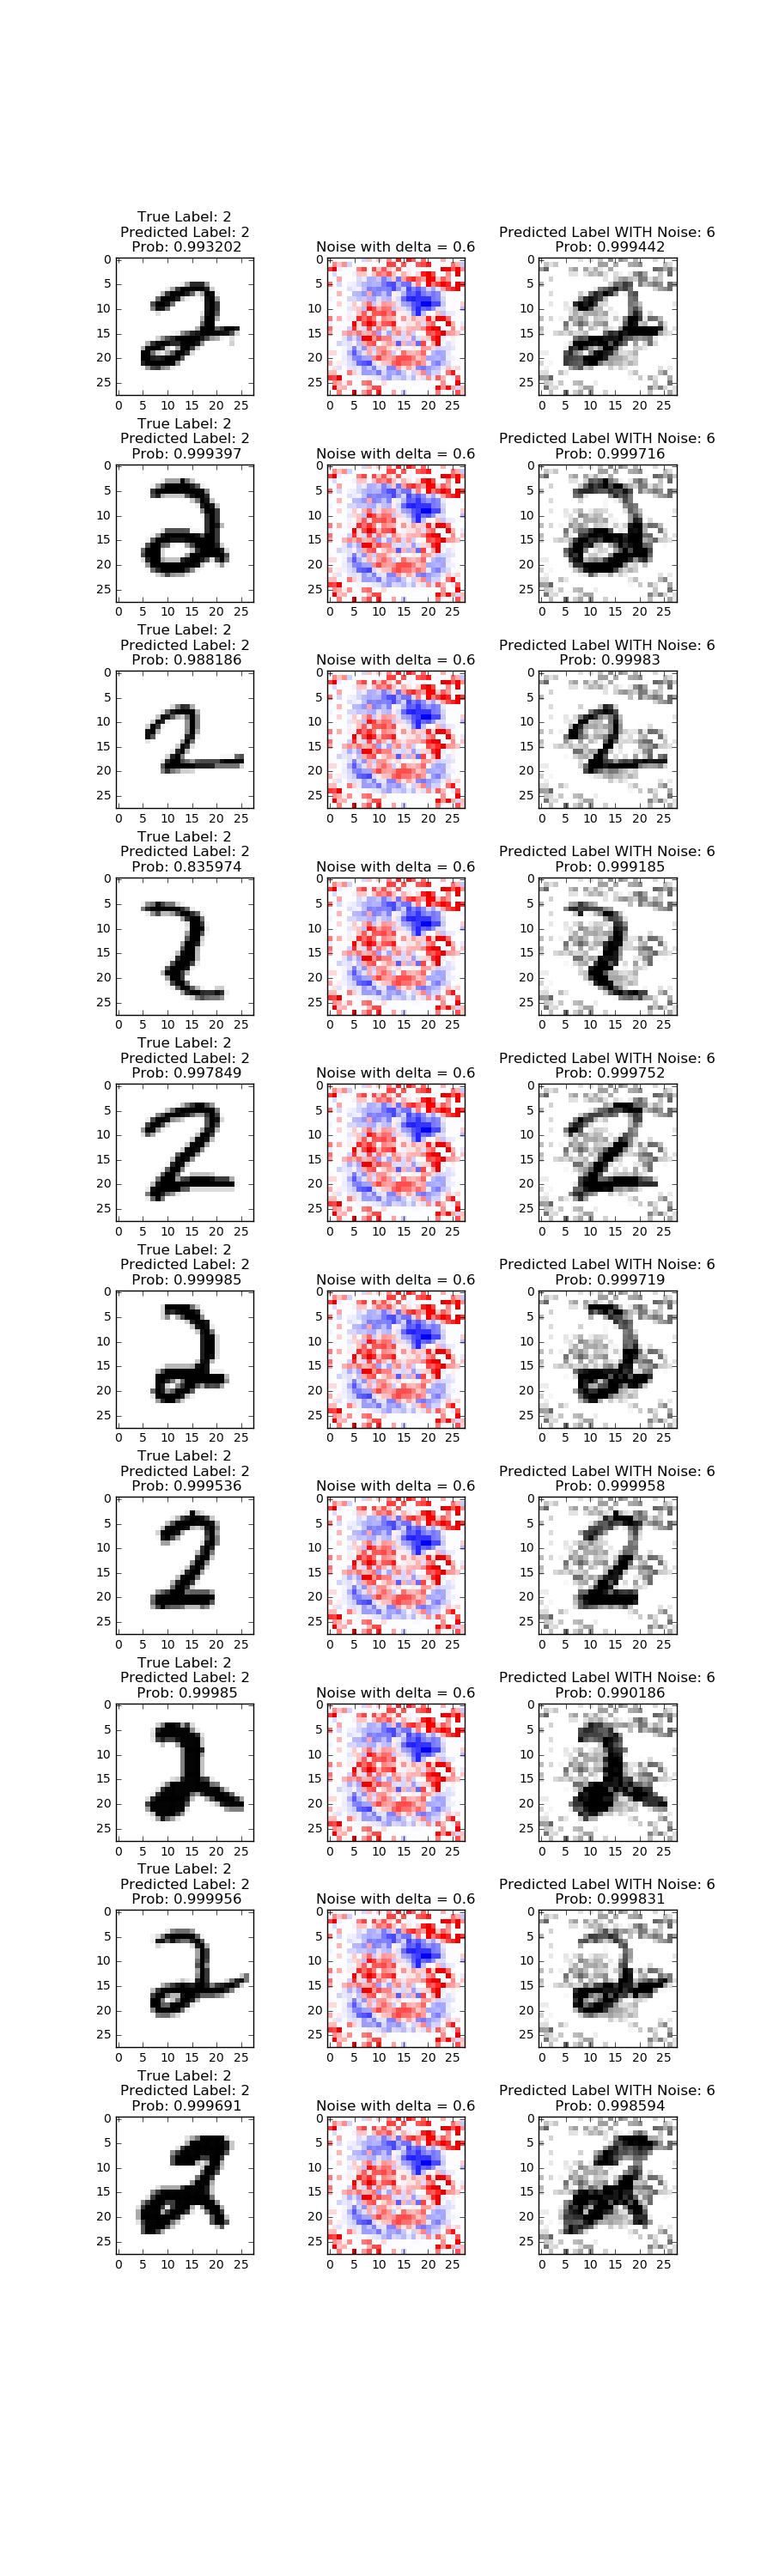

In [217]:
#Show results when delta = 0.6
Image('2_to_6_with_delta_0.6.png')

#### Delta = 0.8

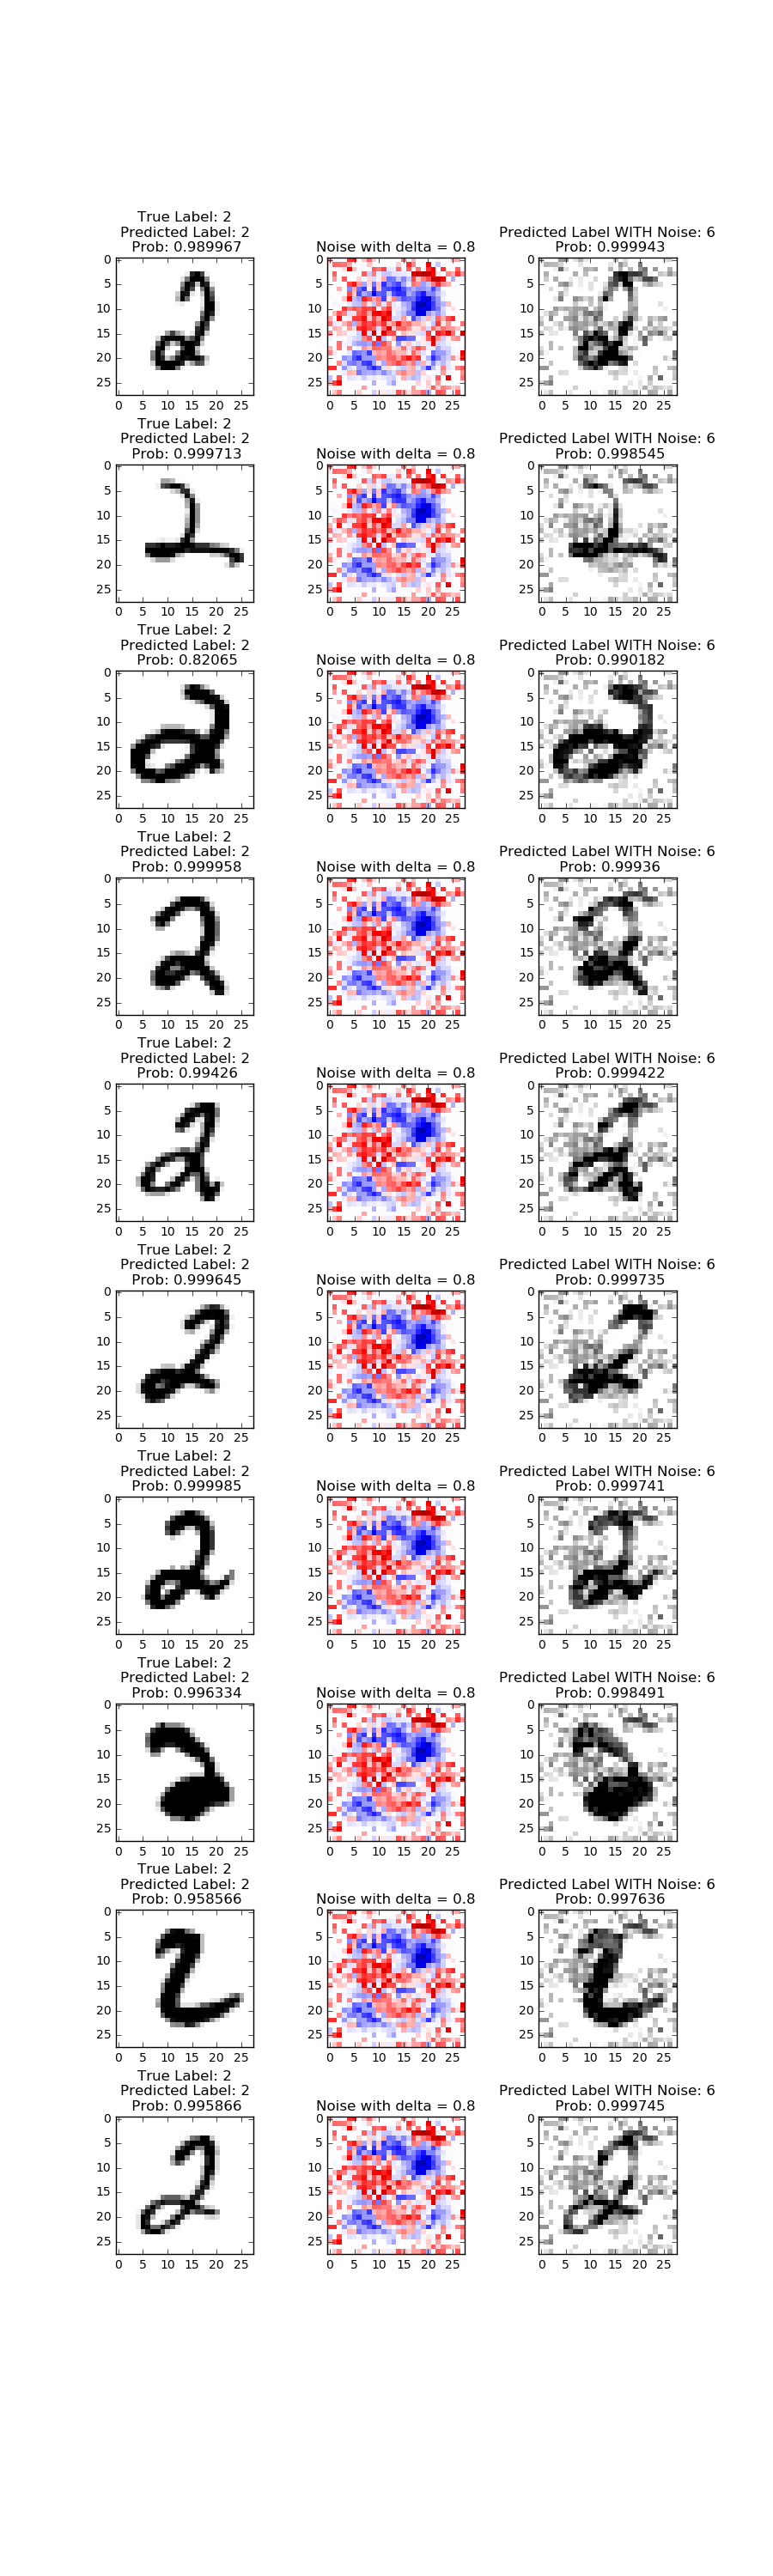

In [218]:
#Show results when delta = 0.8
Image('2_to_6_with_delta_0.8.png')

## Conclution and Discusstion

The model was able to learn specific pattern that can be added to the original image to successfully fool the CNN to always mis-classify an image of 2 as 6 with high accuracy. As shown in the results, the noise pixels are red and blue such that the blue pixels show negative noise value and the red pixels show positive noise value. Also, the blue pixels makes the corresponding original image pixels brighter and the red pixels makes the corresponding original image pixels darker. Moreover, when the noise limit (delta) is small (i.e. 0.2) the noise values will be brighter hence more pixels in the original image will become brighter. Consequently, the effect of the noise will not be major. Simply, the CNN may be able to still recognize the image of 2 as 2 with high level of accuracy. On the other hand, when the noise limit (delta) is high (i.e. 0.8) the noise values will be darker hence more pixels in the original image will become darker. Consequently, the effect of the noise will be major. Simply, the CNN will not be able to recognize the image of 2 as 2 anymore, it will always see it as 6. 